# Neural Network backpropagation implementation from scrath in Python tested with UCLA students admissions dataset

<br>

This notebook is a study of Neural Networks backpropagation step. A simple implementation is done from scratch in Python, and at the end, the proposed solution is tested against UCLA Admissions Dataset (http://www.ats.ucla.edu/).

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset

In [2]:
data = pd.read_csv('../dataset/ucla-admissions')
data.head(5)

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


### Dataset visualization

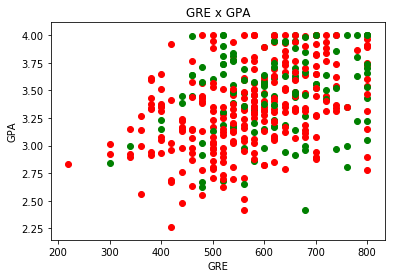

In [3]:
def plot_dataset(data, title=None):
        labels = {1: 'green', 0: 'red'}
        X = np.array(data[['gre','gpa']])
        y = np.array(data['admit'])
        for i in range(0, len(data)):
            plt.scatter(X[i][0], X[i][1], color=labels[y[i]])
        if title:
            plt.title(title)
        plt.xlabel("GRE")
        plt.ylabel("GPA")

plot_dataset(data, "GRE x GPA")
plt.show()

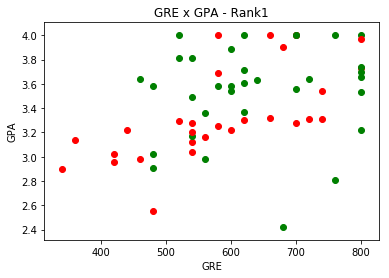

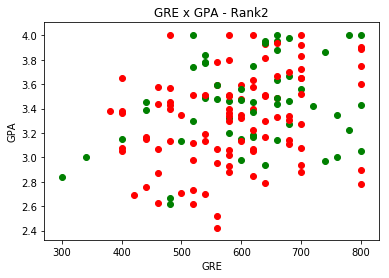

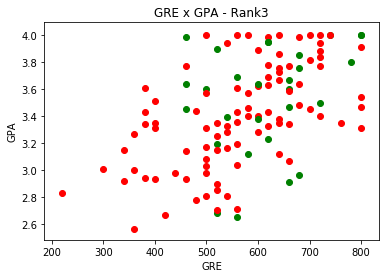

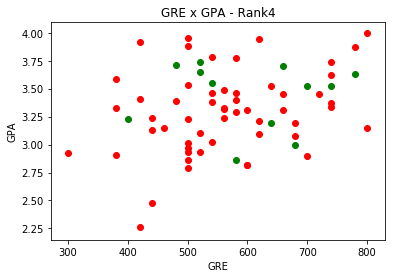

In [4]:
# Group dataset samples by their rank value
rank1_samples = data[data['rank'] == 1]
rank2_samples = data[data['rank'] == 2]
rank3_samples = data[data['rank'] == 3]
rank4_samples = data[data['rank'] == 4]

# Plot dataset samples grouped by rank value
plot_dataset(rank1_samples, "GRE x GPA - Rank1")
plt.show()
plot_dataset(rank2_samples, "GRE x GPA - Rank2")
plt.show()
plot_dataset(rank3_samples, "GRE x GPA - Rank3")
plt.show()
plot_dataset(rank4_samples, "GRE x GPA - Rank4")
plt.show()

It is possible to see that the lower the rank is, the higher the chances of being accepted are.

### Dataset preprocessing

#### One-hot encoding
As the rank feature has a good capacity of describing really well the behaviour of our model, it is necessary to use one hot encoding to transform it from a categorical representation into a binary representation, helping our prediction process.

In [5]:
# Transforms the rank column into one hot encoded columns
rank_one_hot = pd.get_dummies(data['rank'], prefix='rank')
# Add one hot encoded columns to main dataframe and 
# drop old categorical rank column
data = pd.concat([data, rank_one_hot], axis=1)
data = data.drop('rank', axis=1)

In [6]:
data.head(5)

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


#### Data scaling
Not all features have the same value range, making the data skewed, for instance, we have the GRE value of 800 while the GPa max value is only 4.0.

In [7]:
print("Max GRE value : {} | Min GRE value : {}"
      .format(data['gre'].max(),data['gre'].min()))
print("Max GPA value : {} | Min GPA value : {}"
      .format(data['gpa'].max(),data['gpa'].min()))

Max GRE value : 800 | Min GRE value : 220
Max GPA value : 4.0 | Min GPA value : 2.26


To avoid problems during the training of the Neural Network, We need to scale the data, put all features in a range of values between 0 and 1.

For this, all GRE values will be divide by 800 and all GPA values will be divided by 4.0, the max values for both features

In [8]:
data['gre'] = data['gre'] / 800
data['gpa'] = data['gpa'] / 4.0

data.head(5)

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1


#### Split training and testing datasets

In [9]:
sample = np.random.choice(data.index, size=int(len(data)*0.9), replace=False)
train_data, test_data = data.iloc[sample], data.drop(sample)
# Split features and targets
x_train = train_data.drop('admit', axis=1)
y_train = train_data['admit']
x_test = test_data.drop('admit', axis=1)
y_test = test_data['admit']

### 2-layer Neural Network 

Now, the parts of the training phase from a 2-layer Neural Network are implemented.

#### Helper functions

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def error_formula(y, output):
    return -(y * np.log(output)) - (1 - y) * np.log(1 - output)

#### Backpropagation
The back propagation process for the used 2-layer Neural Network is given by the chain rule :

\begin{align}
\frac{\partial E }{\partial h1}\frac{\partial h_1 }{\partial w_1} & = {\sigma}'(x)\cdot -(y-\hat{y})x_j  \\
&= \sigma(x)(1-\sigma(x))\cdot -(y-\hat{y})x_j 
\end{align}

In [11]:
def error_term_formula(x, y, output):
    return (y - output) * sigmoid_prime(x)

In [12]:
# Neural Network hyperparameters
epochs = 1000
learnrate = 0.5

# Function used for training the 2-layer Neural Network, applying both
# feedfoward propagation and backpropagation processes.
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize random weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(x, weights))

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            error_term = error_term_formula(x, y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * x

        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(x_train, y_train, epochs, learnrate)

Epoch: 0
Train loss:  0.2758813653681448
Epoch: 100
Train loss:  0.20620373012829435
Epoch: 200
Train loss:  0.20384528616080044
Epoch: 300
Train loss:  0.2026727560257201
Epoch: 400
Train loss:  0.20205506742495358
Epoch: 500
Train loss:  0.20169370484846882
Epoch: 600
Train loss:  0.20145297176769172
Epoch: 700
Train loss:  0.20127088047200717
Epoch: 800
Train loss:  0.2011185607693331
Epoch: 900
Train loss:  0.2009822579523478
Finished training!
